# Generate training data for exercises
 >__Created__:  2020


In [21]:
import os, sys
import numpy as np
import joblib as jb
import scipy.stats as st 
import pandas as pd
import corner
%matplotlib inline

In [23]:
N   = 30000
mu  = np.array([0.0, 0.0])
cov = np.array([[ 1.0,-0.5],
                [-0.5, 1.5]])
bkg = st.multivariate_normal.rvs(mu, cov, N)
X   = [x for x, y in bkg]
Y   = [y for x, y in bkg]
T   = np.zeros(N)

bkg = pd.DataFrame({'target': T, 'x': X, 'y': Y})
bkg[:10]

,target,x,y
0,0.0,1.563409,-0.980788
1,0.0,-2.703652,3.434184
2,0.0,-0.998775,-0.179813
3,0.0,-0.992434,-0.268595
4,0.0,0.962713,0.642601
5,0.0,-1.360268,2.719343
6,0.0,2.049500,-3.541580
7,0.0,2.587570,-1.237995
8,0.0,1.458587,-1.060499
9,0.0,-0.140261,-0.340959


In [22]:
N   = 20000
mu  = np.array([1.0, 1.0])
cov = np.array([[1.5, 0.5],
                [0.5, 1.5]])
sig = st.multivariate_normal.rvs(mu, cov, N)
X   = [x for x, y in sig]
Y   = [y for x, y in sig]
T   = np.ones(N)

sig = pd.DataFrame({'target': T, 'x': X, 'y': Y})
sig[:10]

,target,x,y
0,1.0,1.721225,1.254035
1,1.0,2.071237,0.971705
2,1.0,1.532396,2.614155
3,1.0,1.210548,0.744006
4,1.0,0.285536,2.232385
5,1.0,0.955370,-0.262267
6,1.0,1.434143,1.446677
7,1.0,2.214791,1.953527
8,1.0,0.044921,-1.350298
9,1.0,-0.917682,1.895389


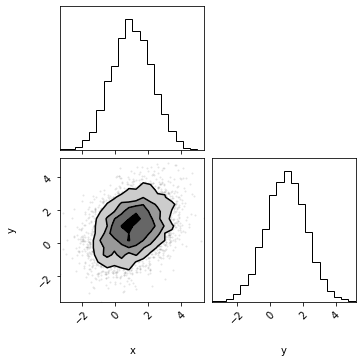

In [14]:
labels = ['x', 'y']
fig = corner.corner(sig[:5000], 
                    labels=labels, 
                    fill_contours=True)
fig.savefig('fig_sig.pdf')

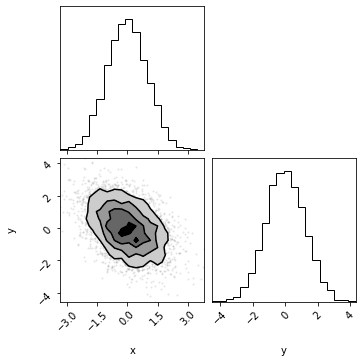

In [15]:
fig = corner.corner(bkg[:5000], 
                    labels=labels, 
                    fill_contours=True)
fig.savefig('fig_bkg.pdf')

In [25]:
data = sig.append(bkg)

In [26]:
len(data)

50000

In [28]:
df = data.sample(frac=1).reset_index(drop=True)
df[:10]
jb.dump(df, 'data.db')

['data.db']